In [4]:
import pandas as pd
import bambi as bmb
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format


In [5]:
PATH = 'results_50'

df = pd.read_csv("data/df_indi_works_occupations.csv", index_col=0)
df['decade'] = df['decade'].apply(lambda x: 50 * round(x / 50))
df = df[df['decade']<=1850]
df.occupation.value_counts()

occupation
Writer               189162
Painter              114547
Musician              48371
Sculptor              29885
Architect             24447
Performing Artist     11686
Name: count, dtype: int64

In [6]:


regions = pd.read_csv(
    "data/ENS - Cultural Index - Countries Databases - region_level.csv"
)
regions["region_name"][regions["region_name"] == "Slav world"] = "East Slavic"
regions = regions[regions["level"] == 2]
regions = regions[regions["region_name"] != "Balkans"]
regions = regions[
    regions["region_name"] != "Eastern Europe"
]  # remove because it takes East Slavic and Central Europe
regions = set(regions["region_name"])
df = df[df["region_name"].isin(regions)]

df["century"] = df["decade"].round(-2)
# Avoid overlapping with Antiquity

df = df[~((df["region_name"] == "Italy") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Portugal") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Spain") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Arabic world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Balkans") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "France") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "United Kingdom") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Low countries") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "East Slavic") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Central Europe") & (df["decade"] < 500))]
#df = df[~((df["region_name"] == "Eastern Europe") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "German world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Latin world") & (df["decade"] > 500))]


df["count"] = df["count_works"]
df_m = df.copy()
df_m = df_m[df_m["count"].isin({0, 1, 2})]  # Not more ?
df_m["y"] = df_m["count"].map({0: 0, 1: 0, 2: 1})



In [7]:
set(df_m.region_name)

{'Arabic world',
 'Central Europe',
 'Chinese world',
 'East Slavic',
 'France',
 'German world',
 'Greek World',
 'Indian world',
 'Italy',
 'Japan',
 'Korea',
 'Latin World',
 'Low countries',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'Spain',
 'United Kingdom'}

In [8]:
df_distribution = df_m[['individual_wikidata_id','occupation']].drop_duplicates()
df_distribution.occupation.value_counts()

occupation
Writer               46994
Painter              20923
Musician             12841
Sculptor              6275
Architect             6197
Performing Artist     2725
Name: count, dtype: int64

In [9]:
df_count_work_model = df_m.copy()
df_count_work_model['count_works'][df_count_work_model['count_works']==0] = 1
df_count_work_model = df_count_work_model.groupby(['region_name'])['count_works'].sum().reset_index()
df_count_work_model = df_count_work_model.rename(columns = {'count_works':'count_works_f1_f2'})


In [10]:
# knots
num_knots = 10
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)
iknots = knots[1:-1]

sample = df_m.copy()
#sample = sample.sample(2000, random_state=42)

In [11]:
#MODEL 3
equation = 'y ~ bs(decade, knots=iknots, intercept=True) + occupation +(1|region_name)'
# SECOND MODEL
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

base_model = bmb.Model(
    equation, 
    sample, 
    family='bernoulli', 
    priors=priors)


base_model_fitted = base_model.fit(
    draws=1000,
    chains=4,
    inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},
)  # important to run faster and sample more efficiently


Modeling the probability that y==1
Compiling...
2024-04-29 09:27:00.040226: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/charles/.venv/lib/python3.10/site-packages/pymc/sampling/jax.py:687: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:02.983066
Sampling...
sample: 100%|██████████| 2000/2000 [04:12<00:00,  7.92it/s, 127 s

### Save Forest Plot

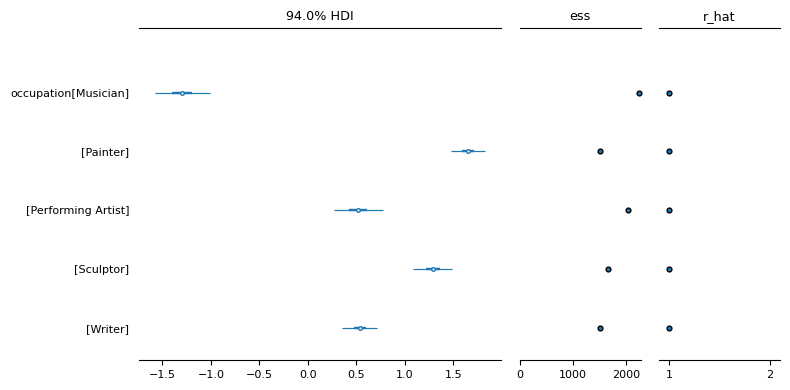

In [12]:
forest_plot = az.plot_forest(
    data=base_model_fitted,
    figsize=(6, 4),
    var_names=["occupation"],
    r_hat=True,
    combined=True,
    textsize=8,
    ess=True,
)

fig = forest_plot[0].get_figure()
fig.set_size_inches(8, 4)  # Adjust size as needed
fig.tight_layout()
#fig.savefig("results/occupation/forest_plot.png")

In [13]:
#region = 'France'
#occupation = 'Architecture'
new_data = {}

#data = df_m[df_m["region_name"] == region]
data = df_m.copy()
new_data["decade"] = data["decade"].values
new_data["occupation"] = data["occupation"].values
new_data["region_name"] =  data["region_name"].values

new_data = pd.DataFrame(new_data)

base_model.predict(base_model_fitted, data=new_data)
posterior_stacked = az.extract(base_model_fitted)
#p = posterior_stacked['y_mean'].values

y_hat = posterior_stacked["y_mean"].values
y_mean = y_hat.mean(axis=1)
hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

In [14]:
# Création du dataset

data['y_mean'] = y_mean
data['y_min'] = hdi_data[0]
data['y_max'] = hdi_data[1]

def compute_f0(p):
    l = (2 * p) / (1 - p)
    f0 = 1 / (l + (l**2) / 2)
    return f0

def compute_f1(y):
    if y ==0:
        return 1
    else:
        return 0

def compute_f2(y):
    if y == 1:
        return 1
    else:
        return 0

data['f0'] = data['y_mean'].apply(lambda x : compute_f0(x))
data['max_f0'] = data['y_min'].apply(lambda x : compute_f0(x))
data['min_f0'] = data['y_max'].apply(lambda x : compute_f0(x))

data['f1'] = data['y'].apply(compute_f1)
data['f2'] = data['y'].apply(compute_f2)

data.to_csv(PATH + '/raw_results.csv')

### Plot Summary table

In [15]:
# Get results for every region
data_group = data.groupby(['region_name']).agg({'f0':'sum', 'min_f0':'sum', 'max_f0':'sum', 'f1':'sum', 'f2':'sum', 'individual_wikidata_id':'count'}).reset_index()
data_group = data_group.rename(columns={'individual_wikidata_id':'N'})

# Get the full number of unseen individuals
data_group['N_unseen'] = data_group['f0'] +  data_group['f1'] +  data_group['f2'] #count ?
data_group['N_unseen_min'] = data_group['min_f0'] +  data_group['f1'] +  data_group['f2']
data_group['N_unseen_max'] = data_group['max_f0'] +  data_group['f1'] +  data_group['f2']

# Merge with the works
df_all_works = df.groupby(['region_name'])['count_works'].sum().reset_index()
data_group = pd.merge(df_all_works, data_group, on = 'region_name')
data_group = data_group.rename(columns={'count_works':'count_works_all'})
data_group = pd.merge(df_count_work_model, data_group, on = 'region_name')


# Compute metrics
data_group['completeness'] = data_group['N']/ data_group['N_unseen']
data_group['coverage'] = 1 - data_group['f1']/ data_group['count_works_all']

# Reorder and format the results
data_group = data_group.set_index('region_name')
data_group = data_group[['N', 'f1', 'f2', 'f0', 'N_unseen', 'completeness','coverage', 'count_works_all', 'count_works_f1_f2','min_f0', 'max_f0', 'N_unseen_min', 'N_unseen_max']]
data_group = data_group.T
data_group


region_name,Arabic world,Central Europe,Chinese world,East Slavic,France,German world,Greek World,Indian world,Italy,Japan,Korea,Latin World,Low countries,Nordic countries,Persian world,Portugal,Spain,United Kingdom
N,1018.00,7096.00,1463.00,3190.00,15755.00,25801.00,1028.00,376.00,13108.00,838.00,174.00,294.00,6557.00,4601.00,450.00,632.00,4370.00,9337.00
f1,952.00,6933.00,1341.00,3084.00,14775.00,24969.00,972.00,345.00,12595.00,778.00,164.00,257.00,6063.00,4396.00,425.00,611.00,4165.00,8724.00
f2,66.00,163.00,122.00,106.00,980.00,832.00,56.00,31.00,513.00,60.00,10.00,37.00,494.00,205.00,25.00,21.00,205.00,613.00
f0,9295.32,292914.43,10521.96,78387.20,237401.44,839420.88,12804.31,3249.51,384979.32,7089.34,1824.17,1172.31,81456.23,101142.79,4720.00,16391.80,106323.62,130745.44
N_unseen,10313.32,300010.43,11984.96,81577.20,253156.44,865221.88,13832.31,3625.51,398087.32,7927.34,1998.17,1466.31,88013.23,105743.79,5170.00,17023.80,110693.62,140082.44
completeness,0.10,0.02,0.12,0.04,0.06,0.03,0.07,0.10,0.03,0.11,0.09,0.20,0.07,0.04,0.09,0.04,0.04,0.07
coverage,0.96,0.57,0.97,0.81,0.85,0.60,0.85,0.66,0.74,0.87,-0.46,0.87,0.92,0.78,0.76,0.72,0.69,0.89
count_works_all,25268.00,15965.00,51252.00,16219.00,96770.00,61711.00,6312.00,1024.00,49091.00,5809.00,112.00,2016.00,75116.00,20370.00,1775.00,2191.00,13229.00,82709.00
count_works_f1_f2,1084.00,7259.00,1585.00,3296.00,16735.00,26633.00,1084.00,407.00,13621.00,898.00,184.00,331.00,7051.00,4806.00,475.00,653.00,4575.00,9950.00
min_f0,7714.41,255124.42,9108.32,67386.03,211787.50,748673.54,9819.63,2555.51,339822.86,5915.90,1369.44,866.18,72398.68,88378.41,3750.52,12931.30,92006.00,116486.08


## Plot model results for every region

[Text(0.5, 0, 'time'), Text(0, 0.5, 'p(n_obs=2)')]

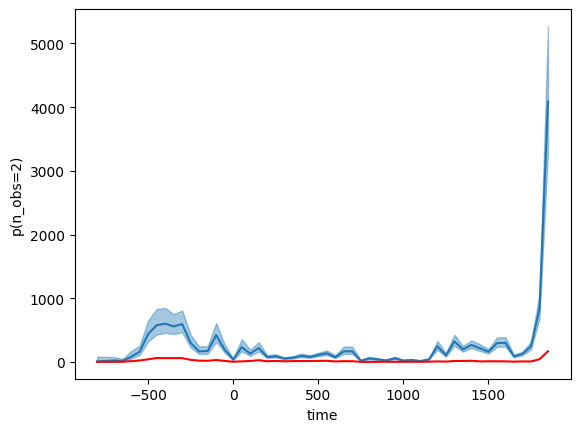

In [16]:
df_filtered = data[data['region_name'] == 'Greek World']

df_filtered = df_filtered.groupby('decade').agg({'f0':'sum', 'f1':'sum', 'f2':'sum', 'min_f0':'sum', 'max_f0':'sum'}).reset_index()
df_filtered['N'] = df_filtered['f1'] + df_filtered['f2'] 
df_filtered['N_unseen'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['f0']
df_filtered['N_unseen_min'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['min_f0']
df_filtered['N_unseen_max'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['max_f0']

fig, ax = plt.subplots()

# Plot predicted line
ax.plot(df_filtered["decade"], df_filtered['N_unseen'], color='C0')
ax.plot(df_filtered["decade"], df_filtered['N'], color='red')


# Plot credibility bands
ax.fill_between(df_filtered["decade"], df_filtered['N_unseen_min'],  df_filtered['N_unseen_max'], alpha=0.4, color='C0')

ax.set(xlabel="time", ylabel="p(n_obs=2)")



### Plot P(Y=2) for every region

[Text(0.5, 0, 'time'), Text(0, 0.5, 'p(n_obs=2)')]

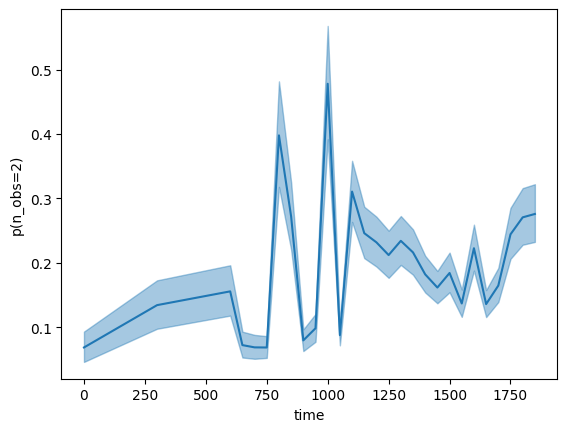

In [17]:
data_f2 = data[['region_name', 'decade', 'y_mean', 'y_min', 'y_max','occupation']].copy()
data_f2 = data_f2.groupby(['region_name', 'decade', 'occupation'])[['y_mean', 'y_min', 'y_max']].mean().reset_index()
data_f2 = data_f2.groupby(['region_name', 'decade'])[['y_mean', 'y_min','y_max']].sum().reset_index()

data_f2_filtered = data_f2[data_f2['region_name']=='Japan']

fig, ax = plt.subplots()

# Plot predicted line
ax.plot(data_f2_filtered["decade"], data_f2_filtered['y_mean'], color='C0')

# Plot credibility bands
ax.fill_between(data_f2_filtered["decade"], data_f2_filtered['y_min'],  data_f2_filtered['y_max'], alpha=0.4, color='C0')

ax.set(xlabel="time", ylabel="p(n_obs=2)")
